# CO416 - Machine Learning for  Imaging

## Coursework 2 - Age regression from brain MRI

Predicting age from a brain MRI scan can have diagnostic value for a number of diseases that cause structural changes and damage to the brain. Discrepancy between the predicted, biological age and the real, chronological age of a patient might indicate the presence of disease and abnormal changes to the brain. For this we need an accurate predictor of brain age which may be learned from a set of healthy reference subjects.
The objective for the coursework is to implement two different supervised learning approaches for age regression from brain MRI. Data from 600 healthy subjects will be provided. Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are dedicated sections in the Jupyter notebook for each approach which contain some detailed instructions, hints and notes.

You may find useful ideas and implementations in the tutorial notebooks. Make sure to add documentation to your code. Markers will find it easier to understand your reasoning when sufficiently detailed comments are provided in your implementations.

#### Read the descriptions and provided code cells carefully and look out for the cells marked with 'TASK'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the population of 600 subjects. Let's start by loading the meta data, that is the data containing information about the subject IDs, their age, and gender.

In [2]:
# Read the meta data using pandas
import pandas as pd

data_dir = "./data/brain/"

meta_data = pd.read_csv(data_dir + 'meta/clean_participant_data.csv')
meta_data.head() # show the first five data entries

,ID,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

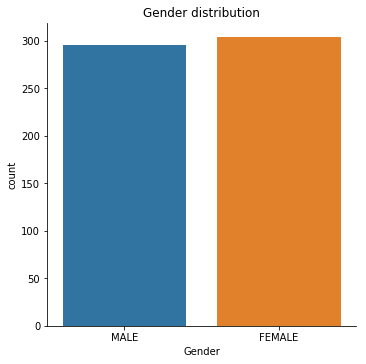

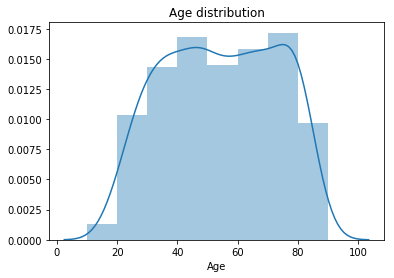

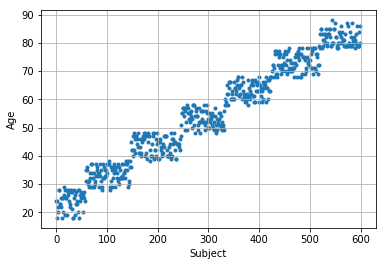

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [4]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

from utils.image_viewer import display_image

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


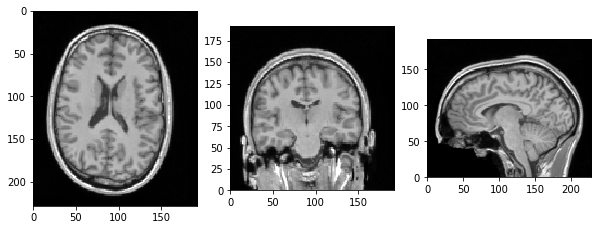

Brain mask (used in part A)


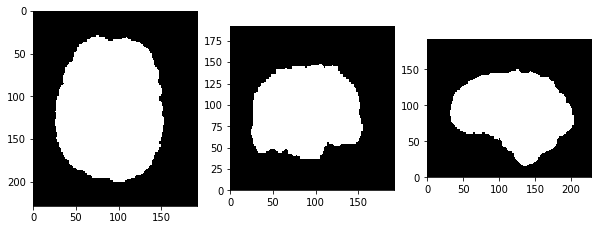

Spatially normalised grey matter maps (used in part B)


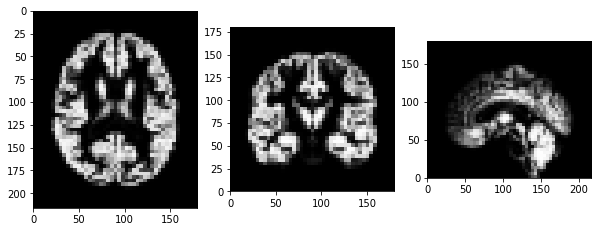

In [5]:
import glob

# Subject with index 0
ID = meta_data['ID'][0]
age = meta_data['age'][0]

# Data folders
image_dir = data_dir + 'images/'
image_filenames = glob.glob(image_dir + '*.nii.gz')

mask_dir = data_dir + 'masks/'
mask_filenames = glob.glob(mask_dir + '*.nii.gz')

greymatter_dir = data_dir + 'greymatter/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')


image_filename = [f for f in image_filenames if ID in f][0]
img = sitk.ReadImage(image_filename)

mask_filename = [f for f in mask_filenames if ID in f][0]
msk = sitk.ReadImage(mask_filename)

greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
gm = sitk.ReadImage(greymatter_filename)
print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B)')
display_image(gm)


## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented and applied to the 600 brain scans. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation, and average age prediction accuracy should be compared and reported appropriately.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a separate dataset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 600 test images. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations for the 600 test images to the reference segmentations. Summarise the statistics of the 600 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run them from the terminal.

#### Imports

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.data_helper import ImageSegmentationDataset

#### Check that the GPU is up and running

In [7]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla K80


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [8]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 80
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**We provide a 'debug' csv file pointing to just a few images for training. Replace this with the full training dataset when you train your full model.**

In [20]:
# USE THIS FOR TRAINING ON ALL 47 SUBJECTS
train_data = data_dir + 'train/csv/train.csv'

# USE THIS FOR DEBUGGING WITH JUST 2 SUBJECTS
# train_data = data_dir + 'train/csv/train.csv'

val_data = data_dir + 'train/csv/val.csv'

print('LOADING TRAINING DATA...')
dataset_train = ImageSegmentationDataset(train_data, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

print('\nLOADING VALIDATION DATA...')
dataset_val = ImageSegmentationDataset(val_data, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

LOADING TRAINING DATA...
+ reading image msub-CC110319_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110319.nii.gz
+ reading mask sub-CC110319_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC120208_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC120208.nii.gz
+ reading mask sub-CC120208_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC120462_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC120462.nii.gz
+ reading mask sub-CC120462_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC121144_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC121144.nii.gz
+ reading mask sub-CC121144_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC122405_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC122405.nii.gz
+ reading mask sub-CC122405_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC210422_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC210422.nii.gz
+ reading mask sub-CC210422_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC220203_T1w_rigid

#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: msub-CC110319_T1w_rigid_to_mni.nii.gz


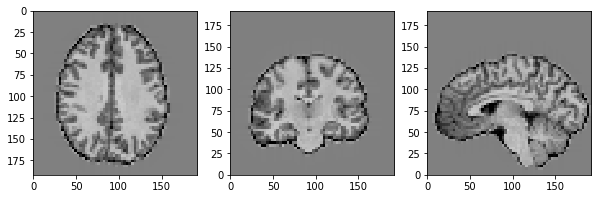

Segmentation: CC110319.nii.gz


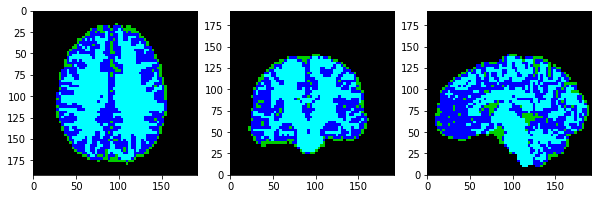

Mask


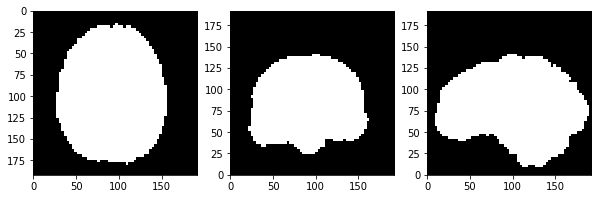

In [21]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation: ' + seg_name)
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [26]:
# class SimpleNet3D(nn.Module):

#     def __init__(self, num_classes):
#         super(SimpleNet3D, self).__init__()
#         self.conv1 = nn.Conv3d(1, 24, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv3d(24, 48, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv3d(48, 4, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

#     def forward(self, x):
# #         print(x.shape)  # 2,1,64,64,64
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.conv4(x)
# #         print(F.softmax(x,dim=1).shape)  # 2,4,64,64,64
#         return F.softmax(x, dim=1)

In [22]:
# modified from archetechtrue of 3DUNet
class UNet3D(nn.Module):
	def __init__(self, in_channels, num_classes, base_n_filter = 16):
		super(UNet3D, self).__init__()
		self.in_channels = in_channels
		self.n_classes = num_classes
		self.base_n_filter = base_n_filter

		self.lrelu = nn.LeakyReLU()
		self.dropout3d = nn.Dropout3d(p=0.6)
		self.upsacle = nn.Upsample(scale_factor=2, mode='nearest')
		self.softmax = nn.Softmax(dim=1)

		# Level 1 context pathway
		self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
		self.conv3d_c1_2 = nn.Conv3d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
		self.norm_lrelu_conv_c1 = self.norm_lrelu_conv(self.base_n_filter, self.base_n_filter)
		self.inorm3d_c1 = nn.InstanceNorm3d(self.base_n_filter)

		# Level 2 context pathway
		self.conv3d_c2 = nn.Conv3d(self.base_n_filter, self.base_n_filter*2, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
		self.inorm3d_c2 = nn.InstanceNorm3d(self.base_n_filter*2)

		# Level 3 context pathway
		self.conv3d_c3 = nn.Conv3d(self.base_n_filter*2, self.base_n_filter*4, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
		self.inorm3d_c3 = nn.InstanceNorm3d(self.base_n_filter*4)

		# Level 4 context pathway
		self.conv3d_c4 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*8, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
		self.inorm3d_c4 = nn.InstanceNorm3d(self.base_n_filter*8)

		# Level 5 context pathway, level 0 localization pathway
		self.conv3d_c5 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*16, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
		self.norm_lrelu_upscale_conv_norm_lrelu_l0 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*8)

		self.conv3d_l0 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*8, kernel_size = 1, stride=1, padding=0, bias=False)
		self.inorm3d_l0 = nn.InstanceNorm3d(self.base_n_filter*8)

		# Level 1 localization pathway
		self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*16)
		self.conv3d_l1 = nn.Conv3d(self.base_n_filter*16, self.base_n_filter*8, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l1 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*4)

		# Level 2 localization pathway
		self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*8)
		self.conv3d_l2 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*4, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l2 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*2)

		# Level 3 localization pathway
		self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*4)
		self.conv3d_l3 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*2, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l3 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter)

		# Level 4 localization pathway
		self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter*2)
		self.conv3d_l4 = nn.Conv3d(self.base_n_filter*2, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)





	def conv_norm_lrelu(self, feat_in, feat_out):
		return nn.Sequential(
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
			nn.InstanceNorm3d(feat_out),
			nn.LeakyReLU())

	def norm_lrelu_conv(self, feat_in, feat_out):
		return nn.Sequential(
			nn.InstanceNorm3d(feat_in),
			nn.LeakyReLU(),
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

	def lrelu_conv(self, feat_in, feat_out):
		return nn.Sequential(
			nn.LeakyReLU(),
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

	def norm_lrelu_upscale_conv_norm_lrelu(self, feat_in, feat_out):
		return nn.Sequential(
			nn.InstanceNorm3d(feat_in),
			nn.LeakyReLU(),
			nn.Upsample(scale_factor=2, mode='nearest'),
			# should be feat_in*2 or feat_in
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
			nn.InstanceNorm3d(feat_out),
			nn.LeakyReLU())

	def forward(self, x):
            # Level 1 context pathway
            out = self.conv3d_c1_1(x)
            out = self.dropout3d(out)
            out = self.norm_lrelu_conv_c1(out)
            out = self.inorm3d_c1(out)
            out = self.lrelu(out)
            context_1 = out

            # Level 2 context pathway
            out = self.conv3d_c2(out)
            out = self.dropout3d(out)
            out = self.norm_lrelu_conv_c2(out)
            out = self.inorm3d_c2(out)
            out = self.lrelu(out)
            context_2 = out

            # Level 3 context pathway
            out = self.conv3d_c3(out)
            out = self.dropout3d(out)
            out = self.norm_lrelu_conv_c3(out)
            out = self.inorm3d_c3(out)
            out = self.lrelu(out)
            context_3 = out


            # Level 4 context pathway
            out = self.conv3d_c4(out)
            out = self.dropout3d(out)
            out = self.norm_lrelu_conv_c4(out)
            out = self.inorm3d_c4(out)
            out = self.lrelu(out)
            context_4 = out


            # Level 5
            out = self.conv3d_c5(out)
            out = self.dropout3d(out)
            out = self.norm_lrelu_conv_c5(out)
            out = self.norm_lrelu_upscale_conv_norm_lrelu_l0(out)

            out = self.conv3d_l0(out)
            out = self.inorm3d_l0(out)
            out = self.lrelu(out)

            # Level 1 localization pathway
            out = torch.cat([out, context_4], dim=1)
            out = self.conv3d_l1(out)
            out = self.norm_lrelu_upscale_conv_norm_lrelu_l1(out)

            # Level 2 localization pathway
            out = torch.cat([out, context_3], dim=1)
            out = self.conv3d_l2(out)
            out = self.norm_lrelu_upscale_conv_norm_lrelu_l2(out)

            # Level 3 localization pathway
            out = torch.cat([out, context_2], dim=1)
            out = self.conv3d_l3(out)
            out = self.norm_lrelu_upscale_conv_norm_lrelu_l3(out)

            # Level 4 localization pathway
            out = torch.cat([out, context_1], dim=1)
            out = self.conv_norm_lrelu_l4(out)
            out_pred = self.conv3d_l4(out)

            out = self.softmax(out_pred)

            return out_pred

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

START TRAINING...


/data/anaconda/envs/mli/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


+ TRAINING 	Epoch: 1 	Loss: 0.652087
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.759380


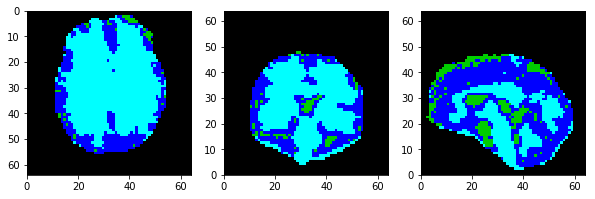

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.465231
+ TRAINING 	Epoch: 3 	Loss: 0.341733
+ TRAINING 	Epoch: 4 	Loss: 0.292380
+ TRAINING 	Epoch: 5 	Loss: 0.235065
+ TRAINING 	Epoch: 6 	Loss: 0.211895
+ TRAINING 	Epoch: 7 	Loss: 0.170839
+ TRAINING 	Epoch: 8 	Loss: 0.169509
+ TRAINING 	Epoch: 9 	Loss: 0.163878
+ TRAINING 	Epoch: 10 	Loss: 0.135722
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.593596


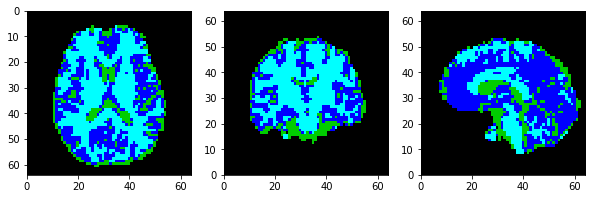

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.128804
+ TRAINING 	Epoch: 12 	Loss: 0.118697
+ TRAINING 	Epoch: 13 	Loss: 0.103109
+ TRAINING 	Epoch: 14 	Loss: 0.125538
+ TRAINING 	Epoch: 15 	Loss: 0.112630
+ TRAINING 	Epoch: 16 	Loss: 0.102036
+ TRAINING 	Epoch: 17 	Loss: 0.091277
+ TRAINING 	Epoch: 18 	Loss: 0.099308
+ TRAINING 	Epoch: 19 	Loss: 0.107053
+ TRAINING 	Epoch: 20 	Loss: 0.111491
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.647322


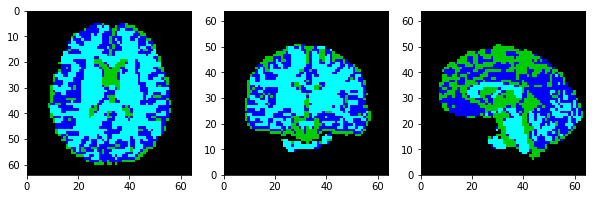

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.117374
+ TRAINING 	Epoch: 22 	Loss: 0.102040
+ TRAINING 	Epoch: 23 	Loss: 0.077947
+ TRAINING 	Epoch: 24 	Loss: 0.088520
+ TRAINING 	Epoch: 25 	Loss: 0.093885
+ TRAINING 	Epoch: 26 	Loss: 0.078435
+ TRAINING 	Epoch: 27 	Loss: 0.079416
+ TRAINING 	Epoch: 28 	Loss: 0.089817
+ TRAINING 	Epoch: 29 	Loss: 0.199302
+ TRAINING 	Epoch: 30 	Loss: 0.075167
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.913998


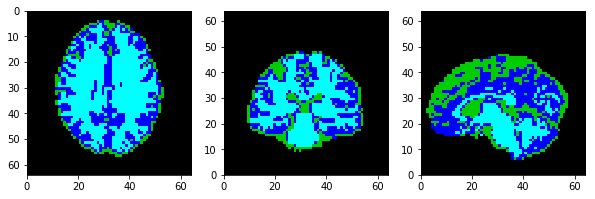

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.080193
+ TRAINING 	Epoch: 32 	Loss: 0.091831
+ TRAINING 	Epoch: 33 	Loss: 0.073501
+ TRAINING 	Epoch: 34 	Loss: 0.083372
+ TRAINING 	Epoch: 35 	Loss: 0.088147
+ TRAINING 	Epoch: 36 	Loss: 0.067121
+ TRAINING 	Epoch: 37 	Loss: 0.071683
+ TRAINING 	Epoch: 38 	Loss: 0.068538
+ TRAINING 	Epoch: 39 	Loss: 0.163613
+ TRAINING 	Epoch: 40 	Loss: 0.081630
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.869725


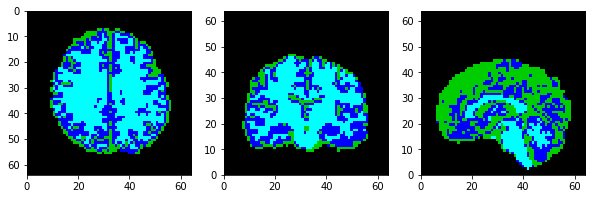

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.101873
+ TRAINING 	Epoch: 42 	Loss: 0.071662
+ TRAINING 	Epoch: 43 	Loss: 0.071951
+ TRAINING 	Epoch: 44 	Loss: 0.064993
+ TRAINING 	Epoch: 45 	Loss: 0.071331
+ TRAINING 	Epoch: 46 	Loss: 0.076974
+ TRAINING 	Epoch: 47 	Loss: 0.074936
+ TRAINING 	Epoch: 48 	Loss: 0.076063
+ TRAINING 	Epoch: 49 	Loss: 0.086642
+ TRAINING 	Epoch: 50 	Loss: 0.070710
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.788217


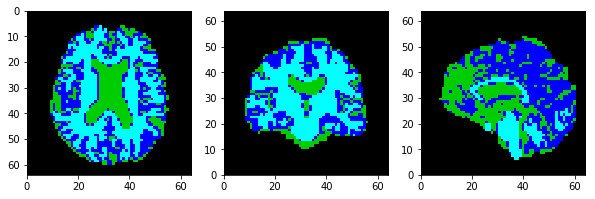

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.078969
+ TRAINING 	Epoch: 52 	Loss: 0.067452
+ TRAINING 	Epoch: 53 	Loss: 0.069016
+ TRAINING 	Epoch: 54 	Loss: 0.070111
+ TRAINING 	Epoch: 55 	Loss: 0.080135
+ TRAINING 	Epoch: 56 	Loss: 0.061784
+ TRAINING 	Epoch: 57 	Loss: 0.067188
+ TRAINING 	Epoch: 58 	Loss: 0.063589
+ TRAINING 	Epoch: 59 	Loss: 0.061538
+ TRAINING 	Epoch: 60 	Loss: 0.074592
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.845062


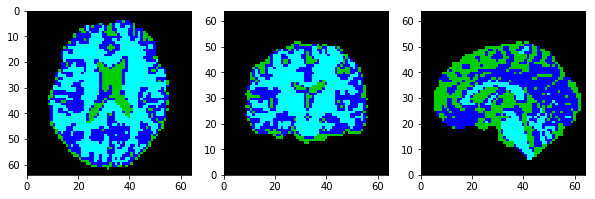

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.059570
+ TRAINING 	Epoch: 62 	Loss: 0.067826
+ TRAINING 	Epoch: 63 	Loss: 0.077328
+ TRAINING 	Epoch: 64 	Loss: 0.067395
+ TRAINING 	Epoch: 65 	Loss: 0.060496
+ TRAINING 	Epoch: 66 	Loss: 0.076822
+ TRAINING 	Epoch: 67 	Loss: 0.072786
+ TRAINING 	Epoch: 68 	Loss: 0.071152
+ TRAINING 	Epoch: 69 	Loss: 0.056515
+ TRAINING 	Epoch: 70 	Loss: 0.052722
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 1.182352


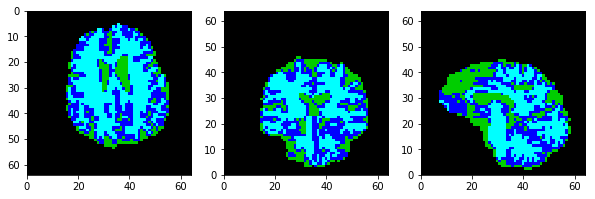

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.066724
+ TRAINING 	Epoch: 72 	Loss: 0.066594
+ TRAINING 	Epoch: 73 	Loss: 0.064420
+ TRAINING 	Epoch: 74 	Loss: 0.061699
+ TRAINING 	Epoch: 75 	Loss: 0.063625
+ TRAINING 	Epoch: 76 	Loss: 0.065461
+ TRAINING 	Epoch: 77 	Loss: 0.062420
+ TRAINING 	Epoch: 78 	Loss: 0.061111
+ TRAINING 	Epoch: 79 	Loss: 0.059126
+ TRAINING 	Epoch: 80 	Loss: 0.057341
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.977548


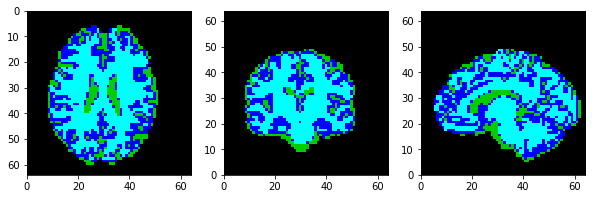

--------------------------------------------------

Finished TRAINING.


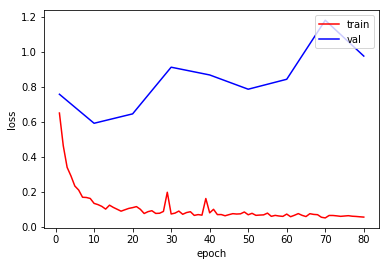

In [23]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = UNet3D(1, num_classes, 16).to(device)
#model = SimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to our test dataset. Before testing on the full 600 subjects, you may want to initially just test on the 5 validation subjects.

In [24]:
# USE THIS FOR TESTING ON THE 600 SUBJECTS
#test_data = data_dir + 'csv/test.csv'

# USE THIS FOR TESTING ON THE 5 VALIDATION SUBJECTS
test_data = data_dir + 'train/csv/val.csv'

print('LOADING TESTING DATA...')
dataset_test = ImageSegmentationDataset(test_data, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

LOADING TESTING DATA...
+ reading image msub-CC220901_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC220901.nii.gz
+ reading mask sub-CC220901_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320698_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320698.nii.gz
+ reading mask sub-CC320698_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420454_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420454.nii.gz
+ reading mask sub-CC420454_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610058_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610058.nii.gz
+ reading mask sub-CC610058_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710679_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710679.nii.gz
+ reading mask sub-CC710679_T1w_rigid_to_mni_brain_mask.nii.gz


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: msub-CC220901_T1w_rigid_to_mni.nii.gz


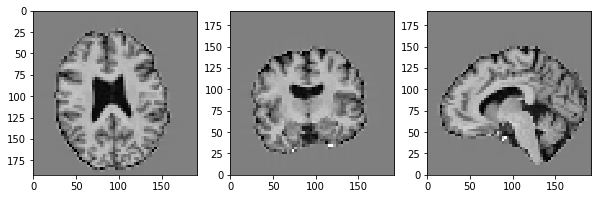

Segmentation: CC220901.nii.gz


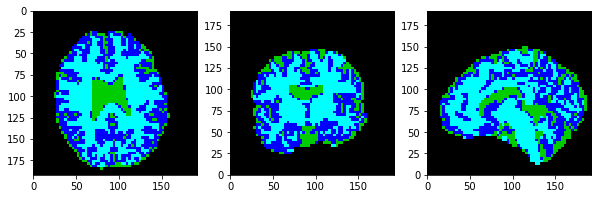

Mask


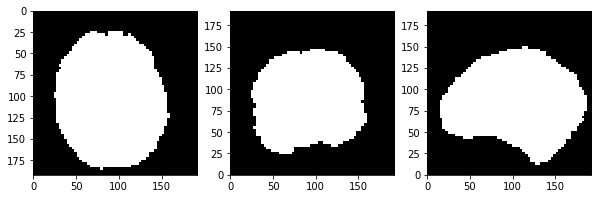

In [25]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation: ' + seg_name)
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

In [28]:
from sklearn import metrics

START TESTING...


/data/anaconda/envs/mli/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


./output/pred CC220901.nii.gz ./output/pred/CC220901.nii.gz
./output/pred CC320698.nii.gz ./output/pred/CC320698.nii.gz
./output/pred CC420454.nii.gz ./output/pred/CC420454.nii.gz
./output/pred CC610058.nii.gz ./output/pred/CC610058.nii.gz
./output/pred CC710679.nii.gz ./output/pred/CC710679.nii.gz
+ TESTING 	Loss: 0.064758 	Acc: 0.973850
precision: [0.99682384 0.89982626 0.84024677 0.93101919]
recall: [0.99797067 0.81778487 0.87307246 0.93336758] 
dsc: [0.99739633 0.85558698 0.85609074 0.93202697]


Reference segmentation


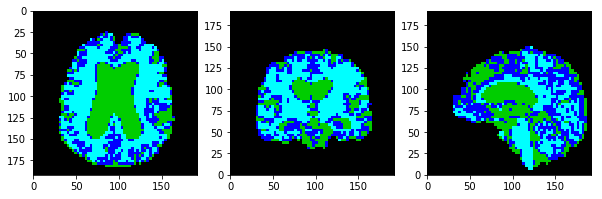

Predicted segmentation


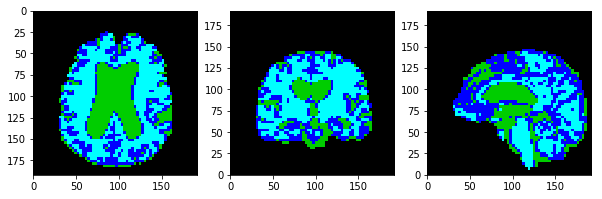


Finished TESTING.


In [29]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

# model = SimpleNet3D(num_classes=num_classes)
model = UNet3D(1, num_classes, 16).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
acc_test = 0
precision_test = 0
recall_test = 0
dsc_test = 0
number = 0

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        

        ##########################My code for evaluation##############################
        number += 1
        prd_squeeze = torch.argmax(prd, dim=1).squeeze()
        seg_squeeze = seg.squeeze()
        prd_1d = prd_squeeze.view(prd_squeeze.size(0)*prd_squeeze.size(0)*prd_squeeze.size(0))
        seg_1d = seg_squeeze.view(seg_squeeze.size(0)*seg_squeeze.size(0)*seg_squeeze.size(0))
        acc_test += metrics.accuracy_score(seg_1d.cpu().numpy(), prd_1d.cpu().numpy())
        
        confusion = metrics.confusion_matrix(seg_1d.cpu().numpy(), prd_1d.cpu().numpy())
        FP = confusion.sum(axis=0) - np.diag(confusion)  
        FN = confusion.sum(axis=1) - np.diag(confusion)
        TP = np.diag(confusion)
        TN = confusion.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        plus = TP / (TP + FP)
        plus[TP == 0] = 0
        precision_test += plus

        plus = TP / (TP + FN)
        plus[TP == 0] = 0
        recall_test += plus

        plus = 2*TP / (2*TP + FP + FN)
        plus[TP == 0] = 0
        dsc_test += plus
        ################################################################################
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        print(pred_dir, name, os.path.join(pred_dir, name))
        
        idx_test += 1

loss_test /= sum_pts
acc_test /= number
precision_test /= number
recall_test /= number
dsc_test /= number
print('+ TESTING \tLoss: {:.6f} \tAcc: {:.6f}'.format(loss_test, acc_test, precision_test, recall_test, dsc_test))
print('precision: {}'.format(precision_test))
print('recall: {} '.format(recall_test))
print('dsc: {}'.format(dsc_test))
# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

# loss_test /= sum_pts

# print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# # Show last testing sample as an example
# print('\n\nReference segmentation')
# display_image(sitk.LabelToRGB(sample['seg']))
# print('Predicted segmentation')
# display_image(sitk.LabelToRGB(prediction))

# print('\nFinished TESTING.')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [31]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

data_dir = "./data/brain/"
seg_dir = data_dir + './segs_refs/'
# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
# seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
seg_dir = data_dir + './segs_refs/'  # data_dir = "./data/brain/"

vols = np.zeros((3,meta_data['ID'].count()))

for i in range(meta_data['ID'].count()):

########################################
# ADD YOUR CODE HERE
########################################
    ID = meta_data['ID'][i]
    age = meta_data['age'][i]

    seg_filenames = glob.glob(seg_dir + '*.nii.gz')

    seg_filename = [f for f in seg_filenames if ID in f][0]
    seg = sitk.ReadImage(seg_filename)
    np_seg =(sitk.GetArrayViewFromImage(seg))
    _, counts = np.unique(np_seg, return_counts=True)
    #   0: background
    #   1: CSF
    #   2: GM
    #   3: WM
    
    n_GM = counts[2] 
    n_WM = counts[3]
    n_CSF = counts[1]
    vols[1][i] = n_GM
    vols[2][i] = n_WM
    vols[0][i] = n_CSF

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(sitk.LabelToRGB(seg))

Plot features versus age.

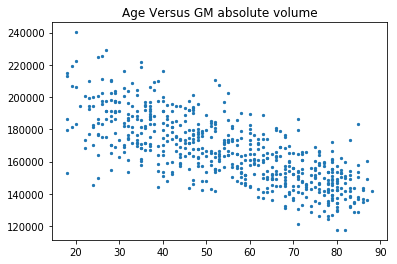

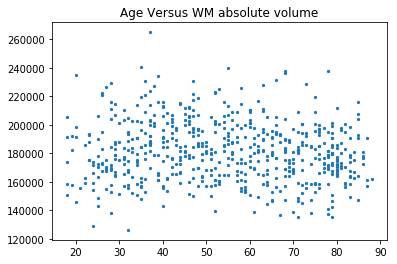

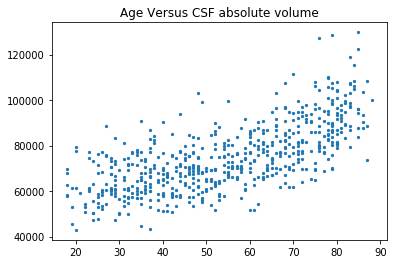

In [32]:
########################################
# ADD YOUR CODE HERE
########################################
plt.figure()
plt.title("Age Versus GM absolute volume")
plt.scatter(meta_data['age'],vols[1], s = 5)
plt.show()
plt.figure()
plt.title("Age Versus WM absolute volume")
plt.scatter(meta_data['age'],vols[2], s = 5 )
plt.show()
plt.figure()
plt.title("Age Versus CSF absolute volume")
plt.scatter(meta_data['age'],vols[0], s = 5 )
plt.show()

In [33]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,meta_data['ID'].count()))

########################################
# ADD YOUR CODE HERE
########################################
for i in range(meta_data['ID'].count()):
    ID = meta_data['ID'][i]
    age = meta_data['age'][i]

    seg_filenames = glob.glob(seg_dir + '*.nii.gz')

    seg_filename = [f for f in seg_filenames if ID in f][0]
    seg = sitk.ReadImage(seg_filename)
    np_seg =(sitk.GetArrayViewFromImage(seg))
    _, counts = np.unique(np_seg, return_counts=True)

    n_GM = counts[2] 
    n_WM = counts[3]
    n_CSF = counts[1]
    vols[0][2] = n_GM
    vols[1][3] = n_WM
    vols[2][1] = n_CSF
    # normalise them
    n_GM = counts[2] 
    n_WM = counts[3]
    n_CSF = counts[1]
    vols_normalised[1][i] = n_GM/(n_GM+n_WM+n_CSF)
    vols_normalised[2][i] = n_WM/(n_GM+n_WM+n_CSF)
    vols_normalised[0][i] = n_CSF/(n_GM+n_WM+n_CSF)

In [34]:
X = vols_normalised.T
y = meta_data['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(600, 3)
(600, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 600 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [36]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

========================== Random Forest ==========================


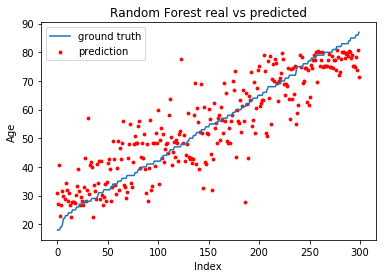

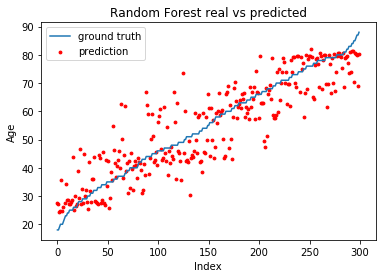

r2 score:  0.7984541256266684
mean absolute error:  6.489016666666666

========================== Gradient Boosting Regressor ==========================


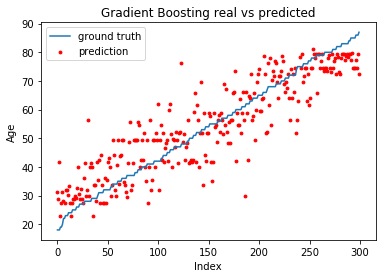

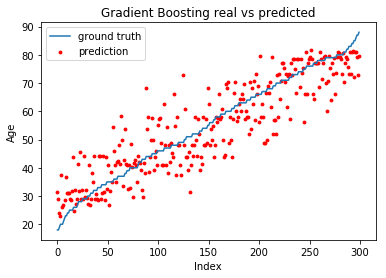

r2 score:  0.7983816091251622
mean absolute error:  6.573514601019259

========================== Gaussian Process Regressor ==========================


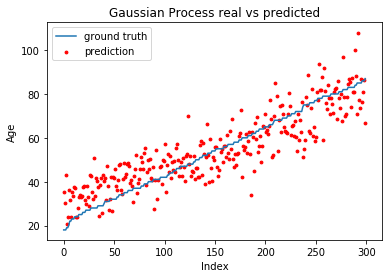

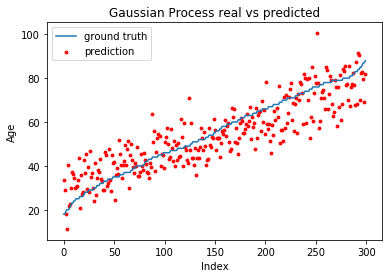

r2 score:  0.7738047944486222
mean absolute error:  7.104329884847005

========================== Comparison of the Performance ==========================


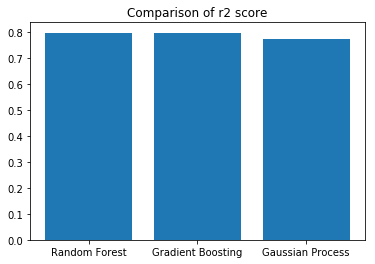

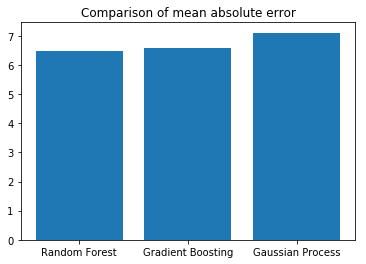

In [37]:
########################################
# ADD YOUR CODE HERE
########################################
# pol_transform = sklearn.preprocessing.PolynomialFeatures(degree=3)
# X_new = pol_transform.fit_transform(X)
X_new = X
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.5, random_state=42)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

r2_list = []
mae_list = []
x_idx = np.arange(300)


################ Random Forest ################
print ("========================== Random Forest ==========================")
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100,max_depth=4, criterion='mae',random_state = 42)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
r2_1 = r2_score(y_test, y_test_pred)
mae_1 = mean_absolute_error(y_test, y_test_pred)

plt.figure()
plt.title("Random Forest real vs predicted")
y_test_sort = np.sort(y_test)
y_test_argsort = np.argsort(y_test)
y_test_pred_sort = y_test_pred[y_test_argsort]
plt.plot(x_idx, y_test_sort, label='ground truth')
plt.scatter(x_idx, y_test_pred_sort, s=8, c='r', label='prediction')
plt.xlabel('Index')
plt.ylabel('Age')
plt.legend()
plt.show()

clf = RandomForestRegressor(n_estimators=100, max_depth=4,criterion='mae',random_state = 42)
clf.fit(X_test, y_test)
y_train_pred = clf.predict(X_train)
r2_2 = r2_score(y_train, y_train_pred)
mae_2 = mean_absolute_error(y_train, y_train_pred)

plt.figure()
plt.title("Random Forest real vs predicted")
y_train_sort = np.sort(y_train)
y_train_argsort = np.argsort(y_train)
y_train_pred_sort = y_train_pred[y_train_argsort]
plt.plot(x_idx, y_train_sort, label='ground truth')
plt.scatter(x_idx, y_train_pred_sort, s=8, c='r', label='prediction')
plt.xlabel('Index')
plt.ylabel('Age')
plt.legend()
plt.show()

r2 = (r2_1 + r2_2) / 2
mae = (mae_1 + mae_2) / 2
r2_list.append(r2)
mae_list.append(mae)
print ("r2 score: ", r2)
print ("mean absolute error: ", mae)



################ Gradient Boosting Regressor ################
print ("\n========================== Gradient Boosting Regressor ==========================")
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, 
                               max_depth = 1, random_state = 42, loss = 'ls')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
r2_1 = r2_score(y_test, y_test_pred)
mae_1 = mean_absolute_error(y_test, y_test_pred)

plt.figure()
plt.title("Gradient Boosting real vs predicted")
y_test_sort = np.sort(y_test)
y_test_argsort = np.argsort(y_test)
y_test_pred_sort = y_test_pred[y_test_argsort]
plt.plot(x_idx, y_test_sort, label='ground truth')
plt.scatter(x_idx, y_test_pred_sort, s=8, c='r', label='prediction')
plt.xlabel('Index')
plt.ylabel('Age')
plt.legend()
plt.show()

clf = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, 
                               max_depth = 1, random_state = 42, loss = 'ls')
clf.fit(X_test, y_test)
y_train_pred = clf.predict(X_train)
r2_2 = r2_score(y_train, y_train_pred)
mae_2 = mean_absolute_error(y_train, y_train_pred)

plt.figure()
plt.title("Gradient Boosting real vs predicted")
y_train_sort = np.sort(y_train)
y_train_argsort = np.argsort(y_train)
y_train_pred_sort = y_train_pred[y_train_argsort]
plt.plot(x_idx, y_train_sort, label='ground truth')
plt.scatter(x_idx, y_train_pred_sort, s=8, c='r', label='prediction')
plt.xlabel('Index')
plt.ylabel('Age')
plt.legend()
plt.show()

r2 = (r2_1 + r2_2) / 2
mae = (mae_1 + mae_2) / 2
r2_list.append(r2)
mae_list.append(mae)
print ("r2 score: ", r2)
print ("mean absolute error: ", mae)

################ Gaussian Process Regressor ################
print ("\n========================== Gaussian Process Regressor ==========================")
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct()
clf = GaussianProcessRegressor(kernel=kernel, random_state = 42)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
r2_1 = r2_score(y_test, y_test_pred)
mae_1 = mean_absolute_error(y_test, y_test_pred)

plt.figure()
plt.title("Gaussian Process real vs predicted")
y_test_sort = np.sort(y_test)
y_test_argsort = np.argsort(y_test)
y_test_pred_sort = y_test_pred[y_test_argsort]
plt.plot(x_idx, y_test_sort, label='ground truth')
plt.scatter(x_idx, y_test_pred_sort, s=8, c='r', label='prediction')
plt.xlabel('Index')
plt.ylabel('Age')
plt.legend()
plt.show()

clf = GaussianProcessRegressor(kernel=kernel, random_state = 42)
clf.fit(X_test, y_test)
y_train_pred = clf.predict(X_train)
r2_2 = r2_score(y_train, y_train_pred)
mae_2 = mean_absolute_error(y_train, y_train_pred)

plt.figure()
plt.title("Gaussian Process real vs predicted")
y_train_sort = np.sort(y_train)
y_train_argsort = np.argsort(y_train)
y_train_pred_sort = y_train_pred[y_train_argsort]
plt.plot(x_idx, y_train_sort, label='ground truth')
plt.scatter(x_idx, y_train_pred_sort, s=8, c='r', label='prediction')
plt.xlabel('Index')
plt.ylabel('Age')
plt.legend()
plt.show()

r2 = (r2_1 + r2_2) / 2
mae = (mae_1 + mae_2) / 2
r2_list.append(r2)
mae_list.append(mae)
print ("r2 score: ", r2)
print ("mean absolute error: ", mae)


print ("\n========================== Comparison of the Performance ==========================")

x = np.arange(3)
plt.figure()
plt.title("Comparison of r2 score")
plt.bar(x, height= r2_list)
plt.xticks(x, ['Random Forest','Gradient Boosting','Gaussian Process'])
plt.show()
plt.figure()
plt.title("Comparison of mean absolute error")
plt.bar(x, height= mae_list)
plt.xticks(x, ['Random Forest','Gradient Boosting','Gaussian Process'])
plt.show()

## Part B: Image-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction using PCA may need to be performed before training a suitable regressor on the low-dimensional feature representation obtained with PCA. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation that had been applied to the maps.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `MLI-MIC-Summary.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

(45, 54, 45) 109350


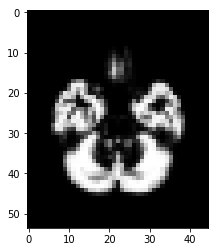

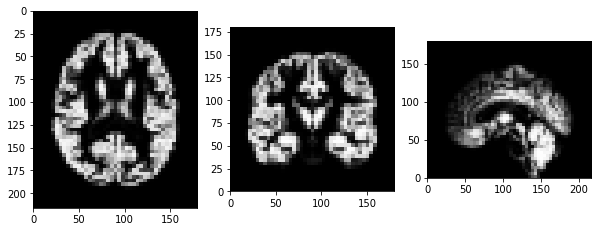

noisy: 


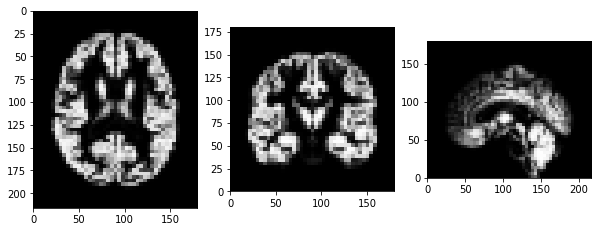

Gaussian smoothing: 


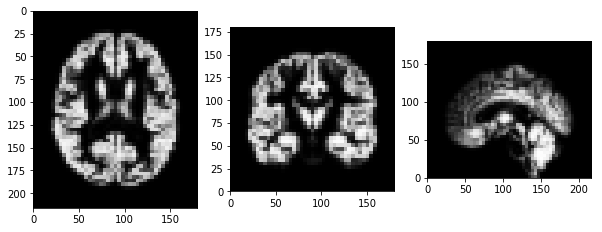

diffusion smoothing: 


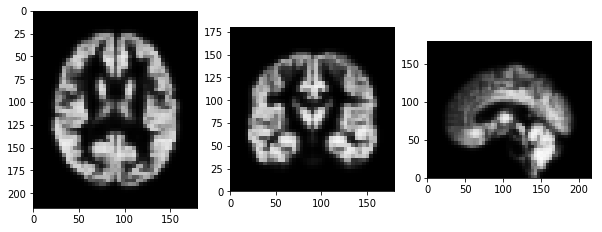

downsampling: 


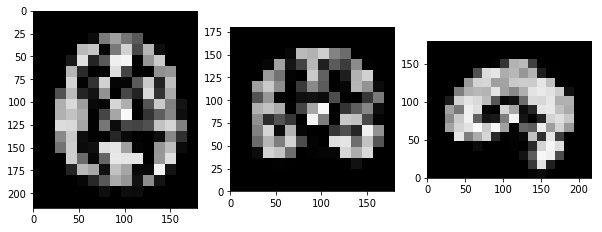

(15, 18, 15) 4050


In [72]:
########################################
# ADD YOUR CODE HERE
########################################
import os
import glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

from utils.image_viewer import display_image

data_dir = "./data/brain/"
ID = meta_data['ID'][0]
# print(len(meta_data['ID']),ID)
age = meta_data['age'][0]
greymatter_dir = data_dir + 'greymatter/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')

greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
gm = sitk.ReadImage(greymatter_filename)

img_array = sitk.GetArrayFromImage(gm)
print(img_array.shape, img_array.shape[0]*img_array.shape[1]*img_array.shape[2])
plt.imshow(img_array[10,:,:], cmap='gray');
display_image(gm)

print('noisy: ')
gm1 = sitk.Cast(gm, sitk.sitkFloat32)
display_image(gm1)

print('Gaussian smoothing: ')
gm2 = sitk.DiscreteGaussian(gm, 1)
display_image(gm2)

print('diffusion smoothing: ')
gm3 = sitk.GradientAnisotropicDiffusion(gm)
display_image(gm3)

print('downsampling: ')
def downsample_naive(img, factor=3):
    return img[::factor, ::factor, ::factor]
gm4=downsample_naive(gm)
display_image(gm4)
img_array = sitk.GetArrayFromImage(gm4)
print(img_array.shape, img_array.shape[0]*img_array.shape[1]*img_array.shape[2])


./data/brain/greymatter/wc1sub-CC110033_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110037_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110045_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110056_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110062_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110069_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110087_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110098_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110101_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110126_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110174_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110182_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110187_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110411_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC110606_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC112141_

./data/brain/greymatter/wc1sub-CC221935_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC221954_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC221977_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC221980_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222125_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222185_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222258_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222264_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222304_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222326_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222367_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222496_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222555_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222652_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC222797_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC223085_

./data/brain/greymatter/wc1sub-CC410173_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410177_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410179_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410182_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410220_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410222_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410226_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410248_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410251_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410284_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410287_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410289_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410297_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410323_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410325_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC410354_

./data/brain/greymatter/wc1sub-CC520168_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520175_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520197_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520200_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520209_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520211_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520215_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520239_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520247_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520254_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520279_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520287_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520377_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520390_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520391_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC520395_

./data/brain/greymatter/wc1sub-CC710037_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710088_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710099_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710131_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710154_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710176_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710214_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710313_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710342_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710350_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710382_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710429_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710446_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710462_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710486_T1w_rigid_to_mni.nii.gz
./data/brain/greymatter/wc1sub-CC710494_

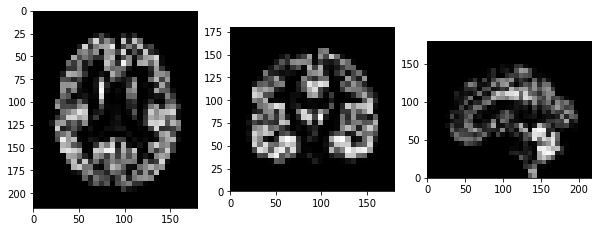

In [89]:
import os
import glob

def downsample_naive(img, factor=3):
    return img[::factor, ::factor, ::factor]
data_dir = "./data/brain/"
# smoothing test data saved in /data/brain/greymatter_smooth
for _, ID in enumerate (meta_data['ID']):
    greymatter_dir = data_dir + 'greymatter/'
    greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')

    greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
    print(greymatter_filename)
    gm = sitk.ReadImage(greymatter_filename)


    smooth_gm=downsample_naive(sitk.DiscreteGaussian(gm, 1))
    save_dir= data_dir + 'greymatter_smooth'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_filename = save_dir+greymatter_filename.split('greymatter')[1]

    sitk.WriteImage(smooth_gm, save_filename, True)
display_image(smooth_gm)

In [73]:
import os
import glob
data_dir = "./data/brain/train/"
def downsample_naive(img, factor=3):
    return img[::factor, ::factor, ::factor]

# smoothing train data saved in /data/brain/train/greymatter_smooth

greymatter_dir = data_dir + 'greymatter/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')
for i in range(len(greymatter_filenames)):

    greymatter_filename = [f for f in greymatter_filenames][i]
    print(greymatter_filename)
    gm = sitk.ReadImage(greymatter_filename)


    smooth_gm=downsample_naive(sitk.DiscreteGaussian(gm, 1))
    save_dir= data_dir + 'greymatter_smooth'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_filename = save_dir+greymatter_filename.split('greymatter')[1]

    sitk.WriteImage(smooth_gm, save_filename, True)

./data/brain/train/greymatter/wc1sub-CC410243_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC420137_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC410113_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC320574_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC410432_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC710416_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC321899_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC120462_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC621642_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC610058_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC620557_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC620821_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC120208_T1w_rigid_to_mni.nii.gz
./data/brain/train/greymatter/wc1sub-CC710679_T1w_rigid_to_mni.nii.gz
./data/brain/train/g

In [75]:

img_data = sitk.GetArrayFromImage(smooth_gm)
X = img_data #PRE-PROCESSED IMAGE DATA
y = meta_data['age'].values.reshape(-1,1)

print(img_size)
print(X.shape)
print(y.shape)

[64, 64, 64]
(30, 36, 30)
(600, 1)


### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [90]:
import sklearn.decomposition as decomp
import os
import glob


data_dir = "./data/brain/train/"
greymatter_dir = data_dir + 'greymatter_smooth/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')
train_data=[]
for i in range(len(greymatter_filenames)):

    greymatter_filename = [f for f in greymatter_filenames][i]
    gm = sitk.ReadImage(greymatter_filename)
    img_array = sitk.GetArrayFromImage(img).reshape(-1)
    train_data.append(img_array)
train_data=np.array(train_data) 

data_dir = "./data/brain/"
greymatter_dir = data_dir + 'greymatter_smooth/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')
test_data=[]
for i in range(len(greymatter_filenames)):

    greymatter_filename = [f for f in greymatter_filenames][i]
    gm = sitk.ReadImage(greymatter_filename)
    img_array = sitk.GetArrayFromImage(img).reshape(-1)
    test_data.append(img_array)
test_data=np.array(test_data)     
    
# Create PCA instance
pca = decomp.PCA(n_components=0.99)

# Fit the data
pca.fit(train_data)


PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [91]:
print(train_data.shape)
print(test_data.shape)
pca_train_data=pca.transform(train_data)
pca_test_data=pca.transform(test_data)
print(pca_train_data.shape)
print(pca_test_data.shape)

(52, 2490368)
(600, 2490368)
(52, 1)
(600, 1)


### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [86]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
data_dir = "./data/brain/"
meta_data = pd.read_csv(data_dir + 'meta/clean_participant_data.csv')
y_test_data = np.array(meta_data['age'])

X_train, X_test, y_train, y_test = train_test_split(
    pca_test_data, y_test_data, test_size=0.4, random_state=0)

pca = decomp.PCA(n_components=0.95)

pca.fit(X_train)
pca_X_train=pca.transform(X_train)
pca_X_test=pca.transform(X_test)
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)


-0.019375823307419715